In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

# Setting up the Dataset & Workflow

In [4]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/CIFAR-10"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [14]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


# Transforms ---- Normalization

In [15]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
# Images are 32x32 hence the RandomResizedCrop((32,32)...)
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32), scale=(0.8,1.0), ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

# Spliting Training & Validation datasets

In [21]:
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Veryfing our normalization

In [17]:
# The mean should be close to 0 and the standard deviation close to 1 for each channel
imgs, labels = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([0.0231, 0.0006, 0.0005])
Batch std tensor([0.9865, 0.9849, 0.9868])


# Checking our augmentation

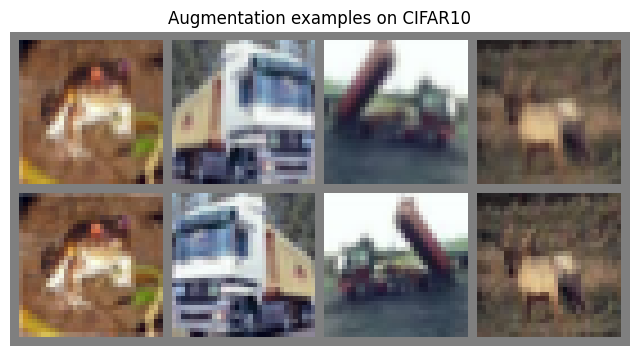

In [25]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

# Making a Neural-Network
## For this case we will be using a CNN

In [27]:
class CNN_CIFAR(nn.Module):
    def __init__(self):
        super(CNN_CIFAR, self).__init__()
        self.conv1=nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool=nn.MaxPool2d(2, 2)
        self.conv2=nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1=nn.Linear(16*5*5, 120)
        self.fc2=nn.Linear(120, 84)
        self.fc3=nn.Linear(84, 10)
        self.dropout=nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [28]:
model = CNN_CIFAR().to(device)
print(model)

CNN_CIFAR(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Loss function and optimizer with a scheduler

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [31]:
def train_model(model, num_epochs=117):
    train_loss=0.0
    val_loss=0.0
    val_loss_min = np.Inf
    train_correct=0
    val_correct=0

    # For plotting purposes
    loss_keeper={'train':[],'val':[]}
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for imgs, labels in train_loader:
            model.train()
            # Step 1: Move input data to device
            imgs, labels = imgs.to(device), labels.to(device)
            # Step 2: Run the model on the input data
            output = model(imgs)
            output = output.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            # Step 3: Calculate the loss
            loss = loss_fn(output, labels)
            # Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()
            # Step 5: Update the parameters
            optimizer.step()

            #Tracking Loss and Accuracy
            train_loss+=loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            train_correct+=pred.eq(labels.view_as(pred)).sum().item()

    # Validation loop
        for imgs, labels in val_loader:
            model.eval()
            imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            output = output.squeeze(dim=1)
            loss = loss_fn(output, labels)
            val_loss+=loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            val_correct+=pred.eq(labels.view_as(pred)).sum().item()


        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)

        loss_keeper['train'].append(train_loss)
        loss_keeper['val'].append(val_loss)
        
        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {val_loss}")
        if val_loss<=val_loss_min:
            print(f"Validation loss decreased from : {val_loss_min} ----> {val_loss} ----> Saving Model.......")
            model_name=type(model).__name__
            torch.save(model.state_dict(), model_name+'_model.pth')
            val_loss_min=val_loss
    return(loss_keeper)

In [32]:
m_loss = train_model(model)

  0%|          | 0/117 [00:00<?, ?it/s]


Epoch : 1	Training Loss : 2.0633219008432153	Validation Loss : 1.9497616052627564
Validation loss decreased from : inf ----> 1.9497616052627564 ----> Saving Model.......

Epoch : 2	Training Loss : 1.9585044566056629	Validation Loss : 1.9474863612651823
Validation loss decreased from : 1.9497616052627564 ----> 1.9474863612651823 ----> Saving Model.......

Epoch : 3	Training Loss : 1.9367238456886098	Validation Loss : 1.8749967535436156
Validation loss decreased from : 1.9474863612651823 ----> 1.8749967535436156 ----> Saving Model.......

Epoch : 4	Training Loss : 1.9524800740571222	Validation Loss : 1.8899589770041405

Epoch : 5	Training Loss : 1.9293447203001324	Validation Loss : 1.8897035568778775

Epoch : 6	Training Loss : 1.9301214284555415	Validation Loss : 1.8956785243000216

Epoch : 7	Training Loss : 1.9455447659043212	Validation Loss : 1.9084258318971734

Epoch : 8	Training Loss : 1.951420759675042	Validation Loss : 1.8894699996735433

Epoch : 9	Training Loss : 1.94322588803624

In [33]:
model.load_state_dict(torch.load('CNN_CIFAR_model.pth'))

C:\Users\top\AppData\Local\Temp\ipykernel_12128\3154970717.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CNN_CIFAR_model.pth'))


<All keys matched successfully>

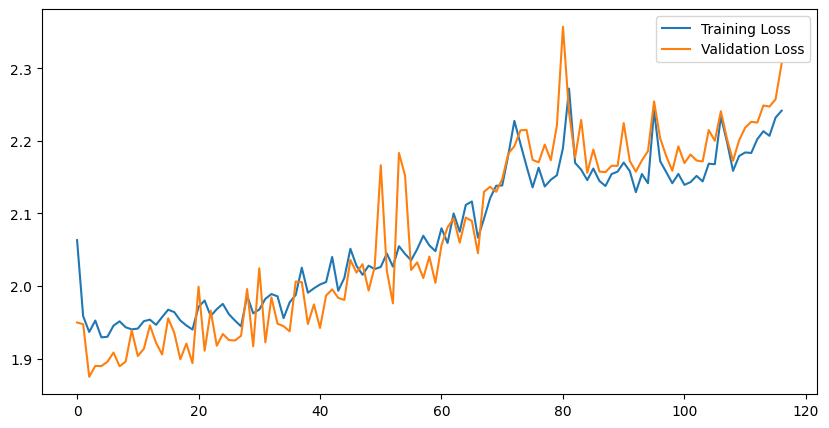

In [34]:
fig, ax=plt.subplots(figsize=(10,5))
ax.plot(m_loss['train'], label="Training Loss")
ax.plot(m_loss['val'], label="Validation Loss")
ax.legend()
plt.show()

In [47]:
def test_model(model, device):
    correct = 0
    total = 0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

    print(f'Accuracy of the network: {100 * correct / total:.2f}%')

In [48]:
test_model(model, 'cpu')

Accuracy of the network: 31.19%


# Pre-trained CNN (ResNet / GoogLeNet)

In [ ]:
from torchvision import models

resnet = models.resnet18(pretrained=True)
googlenet = models.googlenet(pretrained=True)